# Cardiovascular Response Dynamics to Exercise Stress – Python Implementation
## Model based on differential equations with Michaelis-Menten activation/recovery

$$h'(t) = A1 * W'(t) * M(t) - R(t-t0) * A2 * h(t)^{A3}$$
$$ p'(t) = B1 * W'(t) * M(t) - R(t-t0) * B2 * p(t)^{B3}$$
 where $h = H - H_m, p = P - P_m$ (excess over mean/resting)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

# Model Functions

In [13]:
def michaelis_menten(x):
    """M(x) = x / (1 + x)  → smooth step-like activation"""
    return x / (1 + x) if x >= 0 else 0.0

def recovery_func(x):
    """R(x) = 1 - M(x) = 1 / (1 + x)"""
    return 1.0 / (1.0 + x) if x >= 0 else 1.0

def load_profile(t, t_on=5.0, t_off=25.0, W_max=1.0, ramp_duration=3.0):
    """
    Example load W(t): ramp up to W_max over ramp_duration, hold, then ramp down.
    Returns W(t) and its derivative W'(t) via interpolation.
    """
    if t < t_on:
        return 0.0, 0.0
    elif t_on <= t < t_on + ramp_duration:
        frac = (t - t_on) / ramp_duration
        W = W_max * frac
        Wp = W_max / ramp_duration
        return W, Wp
    elif t_on + ramp_duration <= t < t_off:
        return W_max, 0.0
    elif t_off <= t < t_off + ramp_duration:
        frac = (t - t_off) / ramp_duration
        W = W_max * (1 - frac)
        Wp = -W_max / ramp_duration
        return W, Wp
    else:
        return 0.0, 0.0


In [14]:
# Vectorized version for array t
def W_and_Wp(t_array, t_on=5.0, t_off=25.0, W_max=1.0, ramp=3.0):
    W = np.zeros_like(t_array)
    Wp = np.zeros_like(t_array)
    for i, t in enumerate(t_array):
        W[i], Wp[i] = load_profile(t, t_on, t_off, W_max, ramp)
    return W, Wp


# ODE Right-Hand Side

In [15]:
def cardio_ode(y, t, A1, A2, A3, B1, B2, B3, t0_delay, W_interp, Wp_interp):
    h, p = y

    # Interpolate current W(t) and W'(t)
    Wt = W_interp(t)
    Wpt = Wp_interp(t)

    # Delayed arguments (clamp to avoid t-t0 < 0)
    arg_delay = max(t - t0_delay, 0.0)
    Mt = michaelis_menten(W_interp(arg_delay))
    Rt = recovery_func(W_interp(arg_delay))

    # dh/dt and dp/dt
    dhdt = A1 * Wpt * Mt - Rt * A2 * (h ** A3)
    dpdt = B1 * Wpt * Mt - Rt * B2 * (p ** B3)

    return [dhdt, dpdt]

# Simulate with given parameters

In [16]:
def simulate_cardio(t, params_A, params_B, t0_delay=1.5,
                    t_on=5.0, t_off=25.0, W_max=1.0, ramp=3.0):
    A1, A2, A3 = params_A
    B1, B2, B3 = params_B

    # Precompute W(t) and W'(t) on fine grid → interpolation
    t_fine = np.linspace(0, t.max(), 2000)
    W_fine, Wp_fine = W_and_Wp(t_fine, t_on, t_off, W_max, ramp)
    W_interp = interp1d(t_fine, W_fine, kind='linear', fill_value=0.0, bounds_error=False)
    Wp_interp = interp1d(t_fine, Wp_fine, kind='linear', fill_value=0.0, bounds_error=False)

    # Initial conditions: excess = 0
    y0 = [0.0, 0.0]

    sol = odeint(cardio_ode, y0, t,
                 args=(A1, A2, A3, B1, B2, B3, t0_delay, W_interp, Wp_interp))

    h, p = sol.T
    return h, p

In [17]:
# Example Parameters (tune to match real data)
# These are illustrative – realistic values depend on subject & units
# ────────────────────────────────────────────────
params_A_example = [25.0, 0.18, 1.2]   # A1, A2, A3
params_B_example = [18.0, 0.12, 1.15]  # B1, B2, B3

t_delay_example = 2.0   # seconds delay in recovery activation

# Time grid (seconds)
t = np.linspace(0, 60, 600)

h_excess, p_excess = simulate_cardio(t, params_A_example, params_B_example,
                                      t_delay_example)

# Convert to approximate absolute values (add resting levels)
H_rest = 70     # bpm
P_rest = 120    # mmHg (systolic example)
H = H_rest + h_excess
P = P_rest + p_excess

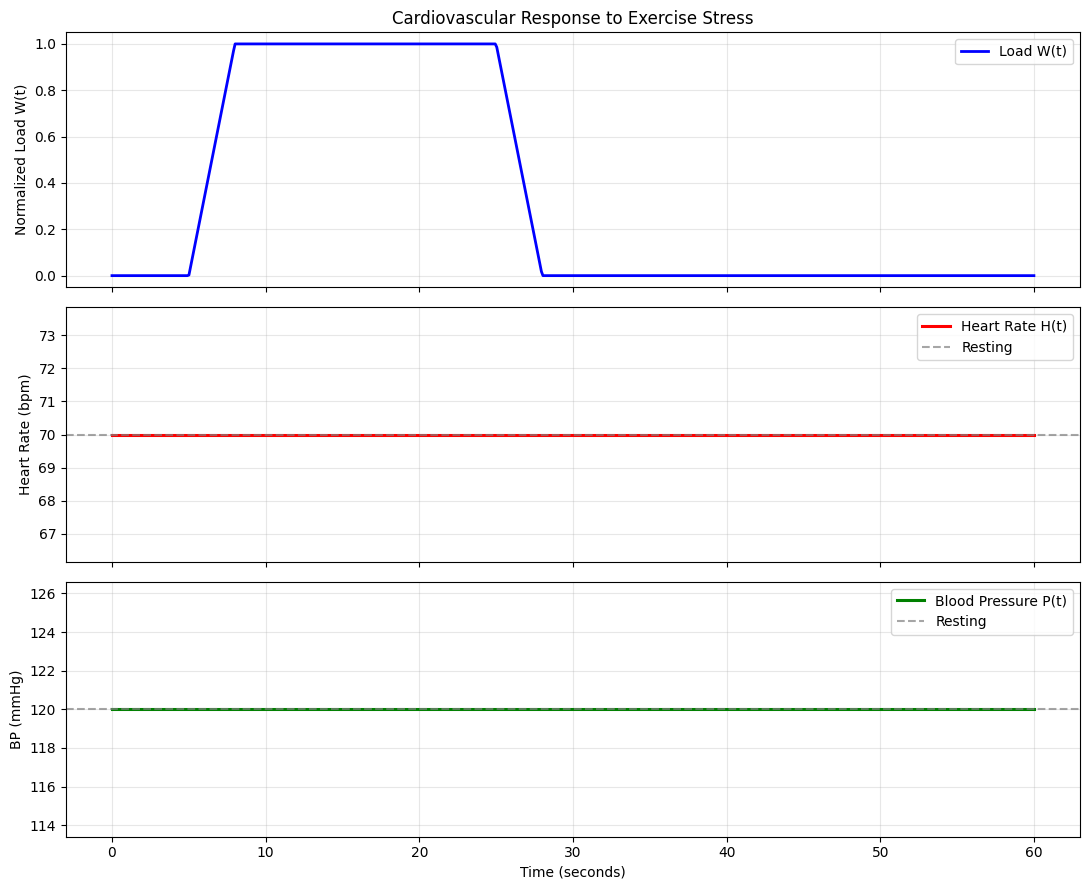

In [18]:
# Plot Results
# ────────────────────────────────────────────────
fig, axs = plt.subplots(3, 1, figsize=(11, 9), sharex=True)


# Load W(t)
W, Wp = W_and_Wp(t)
axs[0].plot(t, W, 'b-', lw=2, label='Load W(t)')
axs[0].set_ylabel('Normalized Load W(t)')
axs[0].set_title('Cardiovascular Response to Exercise Stress')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

# Heart rate
axs[1].plot(t, H, 'r-', lw=2.2, label='Heart Rate H(t)')
axs[1].axhline(H_rest, color='gray', ls='--', alpha=0.7, label='Resting')
axs[1].set_ylabel('Heart Rate (bpm)')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

# Blood pressure
axs[2].plot(t, P, 'g-', lw=2.2, label='Blood Pressure P(t)')
axs[2].axhline(P_rest, color='gray', ls='--', alpha=0.7, label='Resting')
axs[2].set_ylabel('BP (mmHg)')
axs[2].set_xlabel('Time (seconds)')
axs[2].grid(True, alpha=0.3)
axs[2].legend()

plt.tight_layout()
plt.show()

In [19]:
# Parameter Identification Example (simple least-squares fit to fake data)
# ────────────────────────────────────────────────
# Suppose we have measured excess heart rate data (replace with real data!)
t_data = np.array([0, 10, 20, 30, 40, 50, 60])
h_data = np.array([0, 25, 45, 38, 20, 8, 2])   # example bpm excess

In [21]:
def residual_A(params, t_data, h_data, t_delay, W_interp, Wp_interp):
    A1, A2, A3 = params
    # Simulate only h (ignore p for this example)
    def ode_h(y, t):
        return cardio_ode([y, 0], t, A1, A2, A3, 0,0,0, t_delay, W_interp, Wp_interp)[0]

    h_sim = odeint(ode_h, 0.0, t_data).flatten()
    return h_sim - h_data

# Initial guess
A_guess = [20.0, 0.2, 1.0]





In [24]:
# Precompute W(t) and W'(t) for the optimization's time range
# This uses the same load profile parameters as the simulation example
# We'll use the 't' array defined earlier for the simulation as the fine grid for interpolation
t_fine_opt = np.linspace(t.min(), t.max(), 2000) # Use existing simulation time range
W_fine_opt, Wp_fine_opt = W_and_Wp(t_fine_opt) # Using default load_profile parameters
W_interp_opt = interp1d(t_fine_opt, W_fine_opt, kind='linear', fill_value=0.0, bounds_error=False)
Wp_interp_opt = interp1d(t_fine_opt, Wp_fine_opt, kind='linear', fill_value=0.0, bounds_error=False)

# Run optimization (bounds can be added)
res = least_squares(residual_A, A_guess, args=(t_data, h_data, t_delay_example, W_interp_opt, Wp_interp_opt),
                    bounds=([0, 0, 0.5], [100, 1, 2.5]))

print("Fitted parameters A1, A2, A3:", res.x)
print("Cost:", res.cost)

Fitted parameters A1, A2, A3: [20.   0.2  1. ]
Cost: 2281.0


In [22]:
print("\nDone. Experiment with:")
print("- Different load profiles (e.g., multiple steps)")
print("- Real patient data for fitting")
print("- Separate fitting for B parameters")
print("- Adding noise or comparing pre/post-rehabilitation")


Done. Experiment with:
- Different load profiles (e.g., multiple steps)
- Real patient data for fitting
- Separate fitting for B parameters
- Adding noise or comparing pre/post-rehabilitation
